# Jan Zubalewicz & Mateusz Kubita

In [69]:
# The main objective of this project is to build a reliable model to predict athletic performance based on training and physiological data.
# By comparing different machine learning techniques, such as Linear Regression and Gradient Boosting,
# we aim to discover which algorithm best handles the complexity of sports data.
# Ultimately, this analysis helps identify the most effective predictive approach and highlights the key variables that influence final results.

In [70]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from colabtools import drive

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from IPython.display import display

In [71]:
# Link to dataset: https://www.kaggle.com/datasets/programmer3/cross-sport-athlete-performance-dataset?fbclid=IwY2xjawPAWmxleHRuA2FlbQIxMQBzcnRjBmFwcF9pZAEwAAEeaICmR8BF2ijG3Fyx-jhuz4XrVw9Bd3Wh840YA1kZZJ6qtqdq1bKaBtO3ay8_aem_Ynx6kTkZA7zdrMyjEugQbA

In [72]:
raw = drive.LoadFile(file_id='1t3QKjGAACnXGnp2yUYFsE22Wnc3LtwZg')
b = io.BytesIO(raw)
df = pd.read_csv(b)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Analysis

In [73]:
df.head()

,athlete_id,age,gender,sport,vo2_max,hrv,lactate_threshold,resting_heart_rate,max_heart_rate,stride_length,cadence,force_application,power_output,endurance_score,efficiency_score,adaptability_score,skiing_potential
0,RUN_1,23,Female,Running,62.21,116.50,75.97,45,179,1.08,89,466.50,NaN,91.94,75.17,91.67,0.54
1,RUN_2,20,Male,Running,50.98,98.90,78.68,41,198,0.80,65,528.12,NaN,65.22,64.80,80.85,0.13
2,RUN_3,22,Female,Running,68.55,56.96,72.11,49,179,0.92,97,304.43,NaN,50.73,61.85,93.61,0.93
3,RUN_4,26,Female,Running,57.89,56.20,83.94,56,192,0.89,60,520.07,NaN,77.56,94.52,70.17,0.15
4,RUN_5,22,Male,Running,56.31,101.21,80.60,58,176,1.47,66,340.50,NaN,74.46,52.44,52.87,0.03


# Athlete performance dataset

This dataset tracks the physiological, biomechanical, and performance attributes of endurance athletes from **cycling, rowing, and running**.

---

### Dataset Features

* **Physiological Data**
    * **VO₂ max:** Aerobic capacity.
    * **HRV:** Heart rate variability.
    * **Lactate Threshold:** The intensity level before fatigue sets in.
* **Biomechanical Data**
    * **Stride/Cadence:** Movement frequency and length.
    * **Force Application:** How power is delivered during movement.
* **Performance Metrics**
    * **Endurance Capacity:** Overall stamina levels.
    * **Adaptability:** How well the athlete adjusts to new sports.

---

### Target Variable
* **`efficiency_score`**: A predicted metric used to determine an athlete's potential for high performance

## Basic EDA


In [74]:
print("### Basic Descriptive Statistics:\n")
print(df.describe())

print("\n### Missing Values per Column:\n")
print(df.isnull().sum())

print("\n### DataFrame Info (Data Types and Non-Null Counts):\n")
df.info()

### Basic Descriptive Statistics:

               age      vo2_max  ...  adaptability_score  skiing_potential
count  1158.000000  1158.000000  ...         1158.000000       1158.000000
mean     26.044041    62.565328  ...           75.428083          0.501494
std       4.814336    10.259614  ...           14.622505          0.289382
min      18.000000    45.000000  ...           50.020000          0.000000
25%      22.000000    53.447500  ...           62.992500          0.250000
50%      26.000000    62.270000  ...           75.600000          0.500000
75%      30.000000    71.620000  ...           88.557500          0.760000
max      34.000000    79.990000  ...           99.940000          1.000000

[8 rows x 14 columns]

### Missing Values per Column:

athlete_id               0
age                      0
gender                   0
sport                    0
vo2_max                  0
hrv                      0
lactate_threshold        0
resting_heart_rate       0
max_heart_rate    

### Data Preprocessing & Dropped Columns

To refine the dataset for the selection model, several columns have been removed:

* **`power_output`**: This column contained null values and was incomplete, making it unsuitable for training.
* **`force_application`**: This metric was determined to be unnecessary for the specific scope of this runner-to-skier analysis.
* **Redundant Scores**: `endurance_score`, `adaptability_score`, and `skiing_potential` were dropped to focus exclusively on `efficiency_score` as the primary target.
* **`sport`**: Since the dataset has been filtered to include only runners, this categorical column no longer provides predictive value.

In [75]:
columns_to_drop = [
    'athlete_id',
    'sport',
    'force_application',
    'power_output',
    'endurance_score',
    'adaptability_score',
    'skiing_potential'
]

df = df.drop(columns=columns_to_drop)

In [76]:
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158 entries, 0 to 1157
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 1158 non-null   int64  
 1   gender              1158 non-null   int64  
 2   vo2_max             1158 non-null   float64
 3   hrv                 1158 non-null   float64
 4   lactate_threshold   1158 non-null   float64
 5   resting_heart_rate  1158 non-null   int64  
 6   max_heart_rate      1158 non-null   int64  
 7   stride_length       1158 non-null   float64
 8   cadence             1158 non-null   int64  
 9   efficiency_score    1158 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 90.6 KB


In [78]:
df.head()

,age,gender,vo2_max,hrv,lactate_threshold,resting_heart_rate,max_heart_rate,stride_length,cadence,efficiency_score
0,23,1,62.21,116.50,75.97,45,179,1.08,89,75.17
1,20,0,50.98,98.90,78.68,41,198,0.80,65,64.80
2,22,1,68.55,56.96,72.11,49,179,0.92,97,61.85
3,26,1,57.89,56.20,83.94,56,192,0.89,60,94.52
4,22,0,56.31,101.21,80.60,58,176,1.47,66,52.44


- **age**: The age of the individual in years.
- **gender**: The biological sex or gender identity of the participant.
- **vo2_max**: A measurement of the maximum amount of oxygen an individual can utilize during intense exercise.
- **hrv**: Heart Rate Variability, which tracks the time variation between heartbeats to monitor recovery and nervous system stress.
- **lactate_threshold**: The exercise intensity level at which lactate starts to accumulate in the blood faster than it can be cleared.
- **resting_heart_rate**: The number of heartbeats per minute measured while the person is at complete rest.
- **max_heart_rate**: The highest heart rate achieved during maximum physical effort.
- **stride_length**: The distance covered between the point of initial contact of one foot and the next contact of that same foot.
- **cadence**: The frequency of steps taken per minute during running or walking.
- **efficiency_score**: A metric that evaluates how much energy is expended relative to the work or speed produced.

Basic EDA

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_47_gvisor.kernel.colaboratory-playground.2172673883636.14b334fb3717c109/mount/server/notebook.par/google3/third_party/py/joblib/externals/loky/backend/resource_tracker.py:117: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some folders/sempahores might leak.
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_47_gvisor.kernel.colaboratory-playground.2172673883636.14b334fb3717c109/mount/server/notebook.par/google3/third_party/py/joblib/externals/loky/backend/resource_tracker.py:117: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some folders/sempahores might leak.
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/<embedded stdlib>/multiprocessing/util.py", line 227, in __call__
  File "/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_47_gvisor.kernel.colaboratory-playground.2172673883636.14b334fb3

FileNotFoundError: [Errno 2] No such file or directory: '/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_47_gvisor.kernel.colaboratory-playground.2172673883636.14b334fb3717c109/mount/logs.0.colab_kernel_pool_default_47_gvisor.kernel.colaboratory-playground.2172673883636/tmp/tmpemqxr3ge__unpar__.runfiles/google3/third_party/py/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

FileNotFoundError: [Errno 2] No such file or directory: '/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_47_gvisor.kernel.colaboratory-playground.2172673883636.14b334fb3717c109/mount/logs.0.colab_kernel_pool_default_47_gvisor.kernel.colaboratory-playground.2172673883636/tmp/tmpemqxr3ge__unpar__.runfiles/google3/third_party/py/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

<Figure size 1080x864 with 5 Axes>

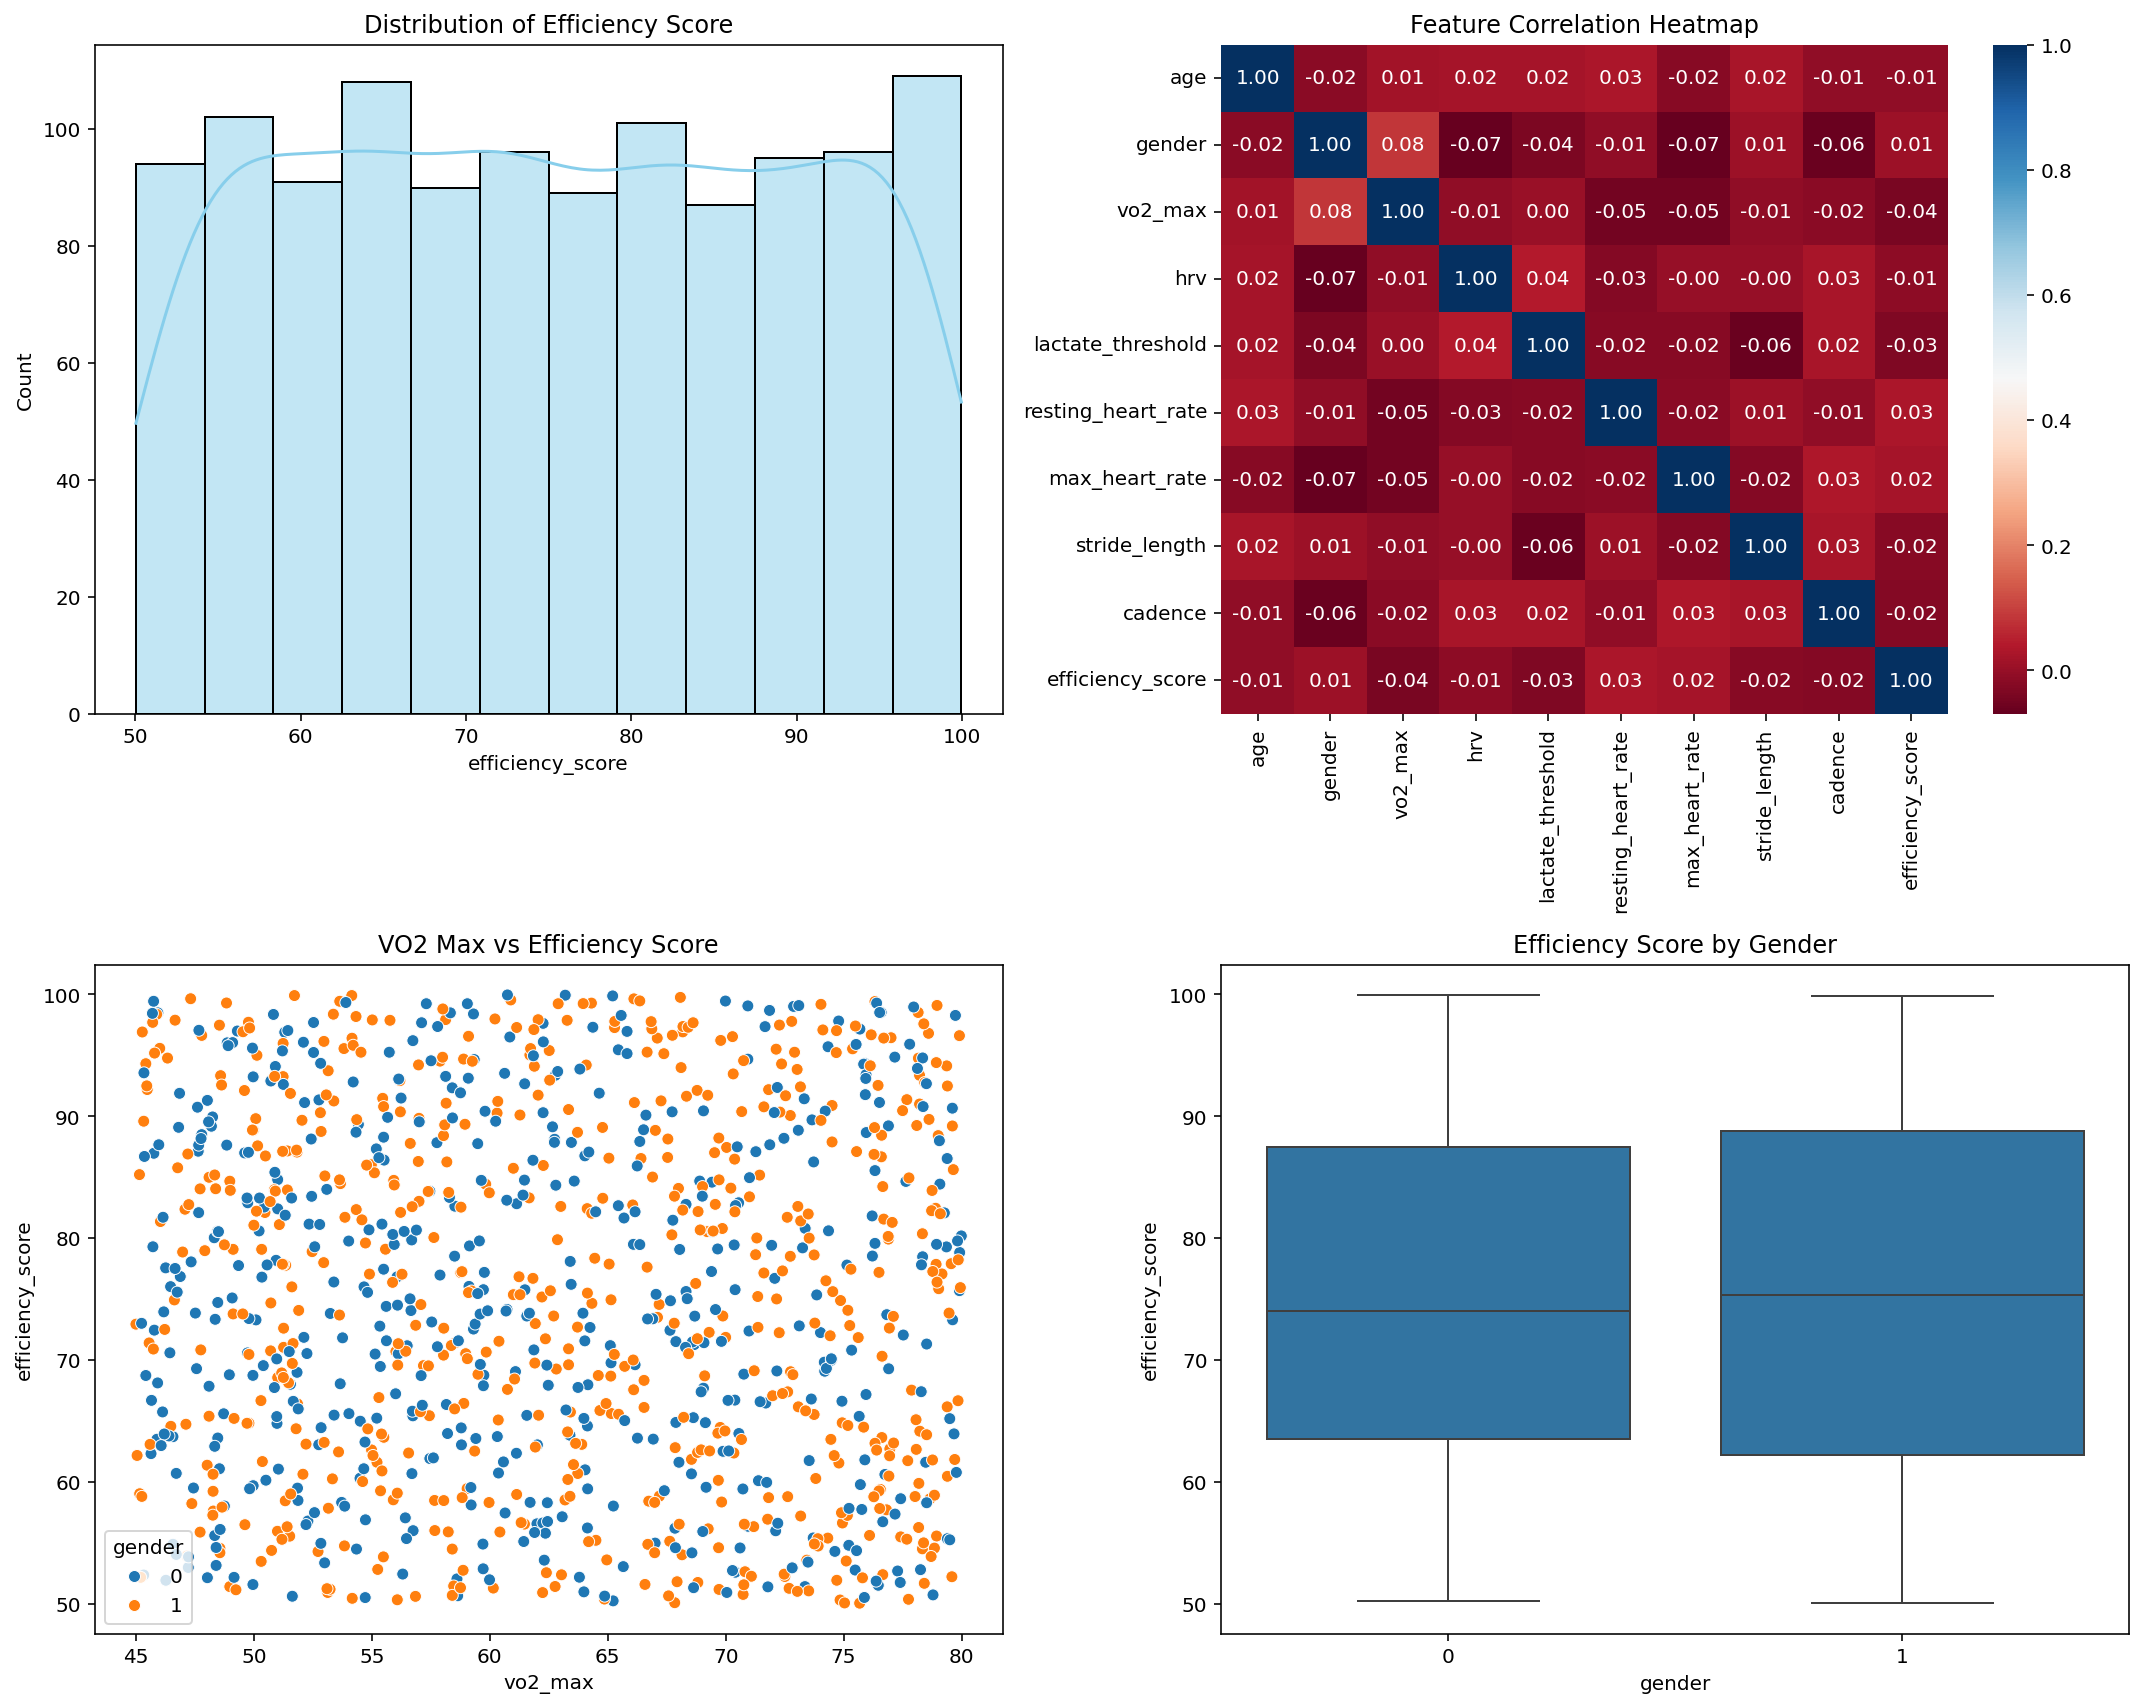

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.histplot(df['efficiency_score'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Efficiency Score')

sns.heatmap(df.corr(), annot=True, cmap='RdBu', fmt=".2f", ax=axes[0, 1])
axes[0, 1].set_title('Feature Correlation Heatmap')

sns.scatterplot(data=df, x='vo2_max', y='efficiency_score', hue='gender', ax=axes[1, 0])
axes[1, 0].set_title('VO2 Max vs Efficiency Score')

sns.boxplot(data=df, x='gender', y='efficiency_score', ax=axes[1, 1])
axes[1, 1].set_title('Efficiency Score by Gender')

plt.tight_layout()
plt.show()

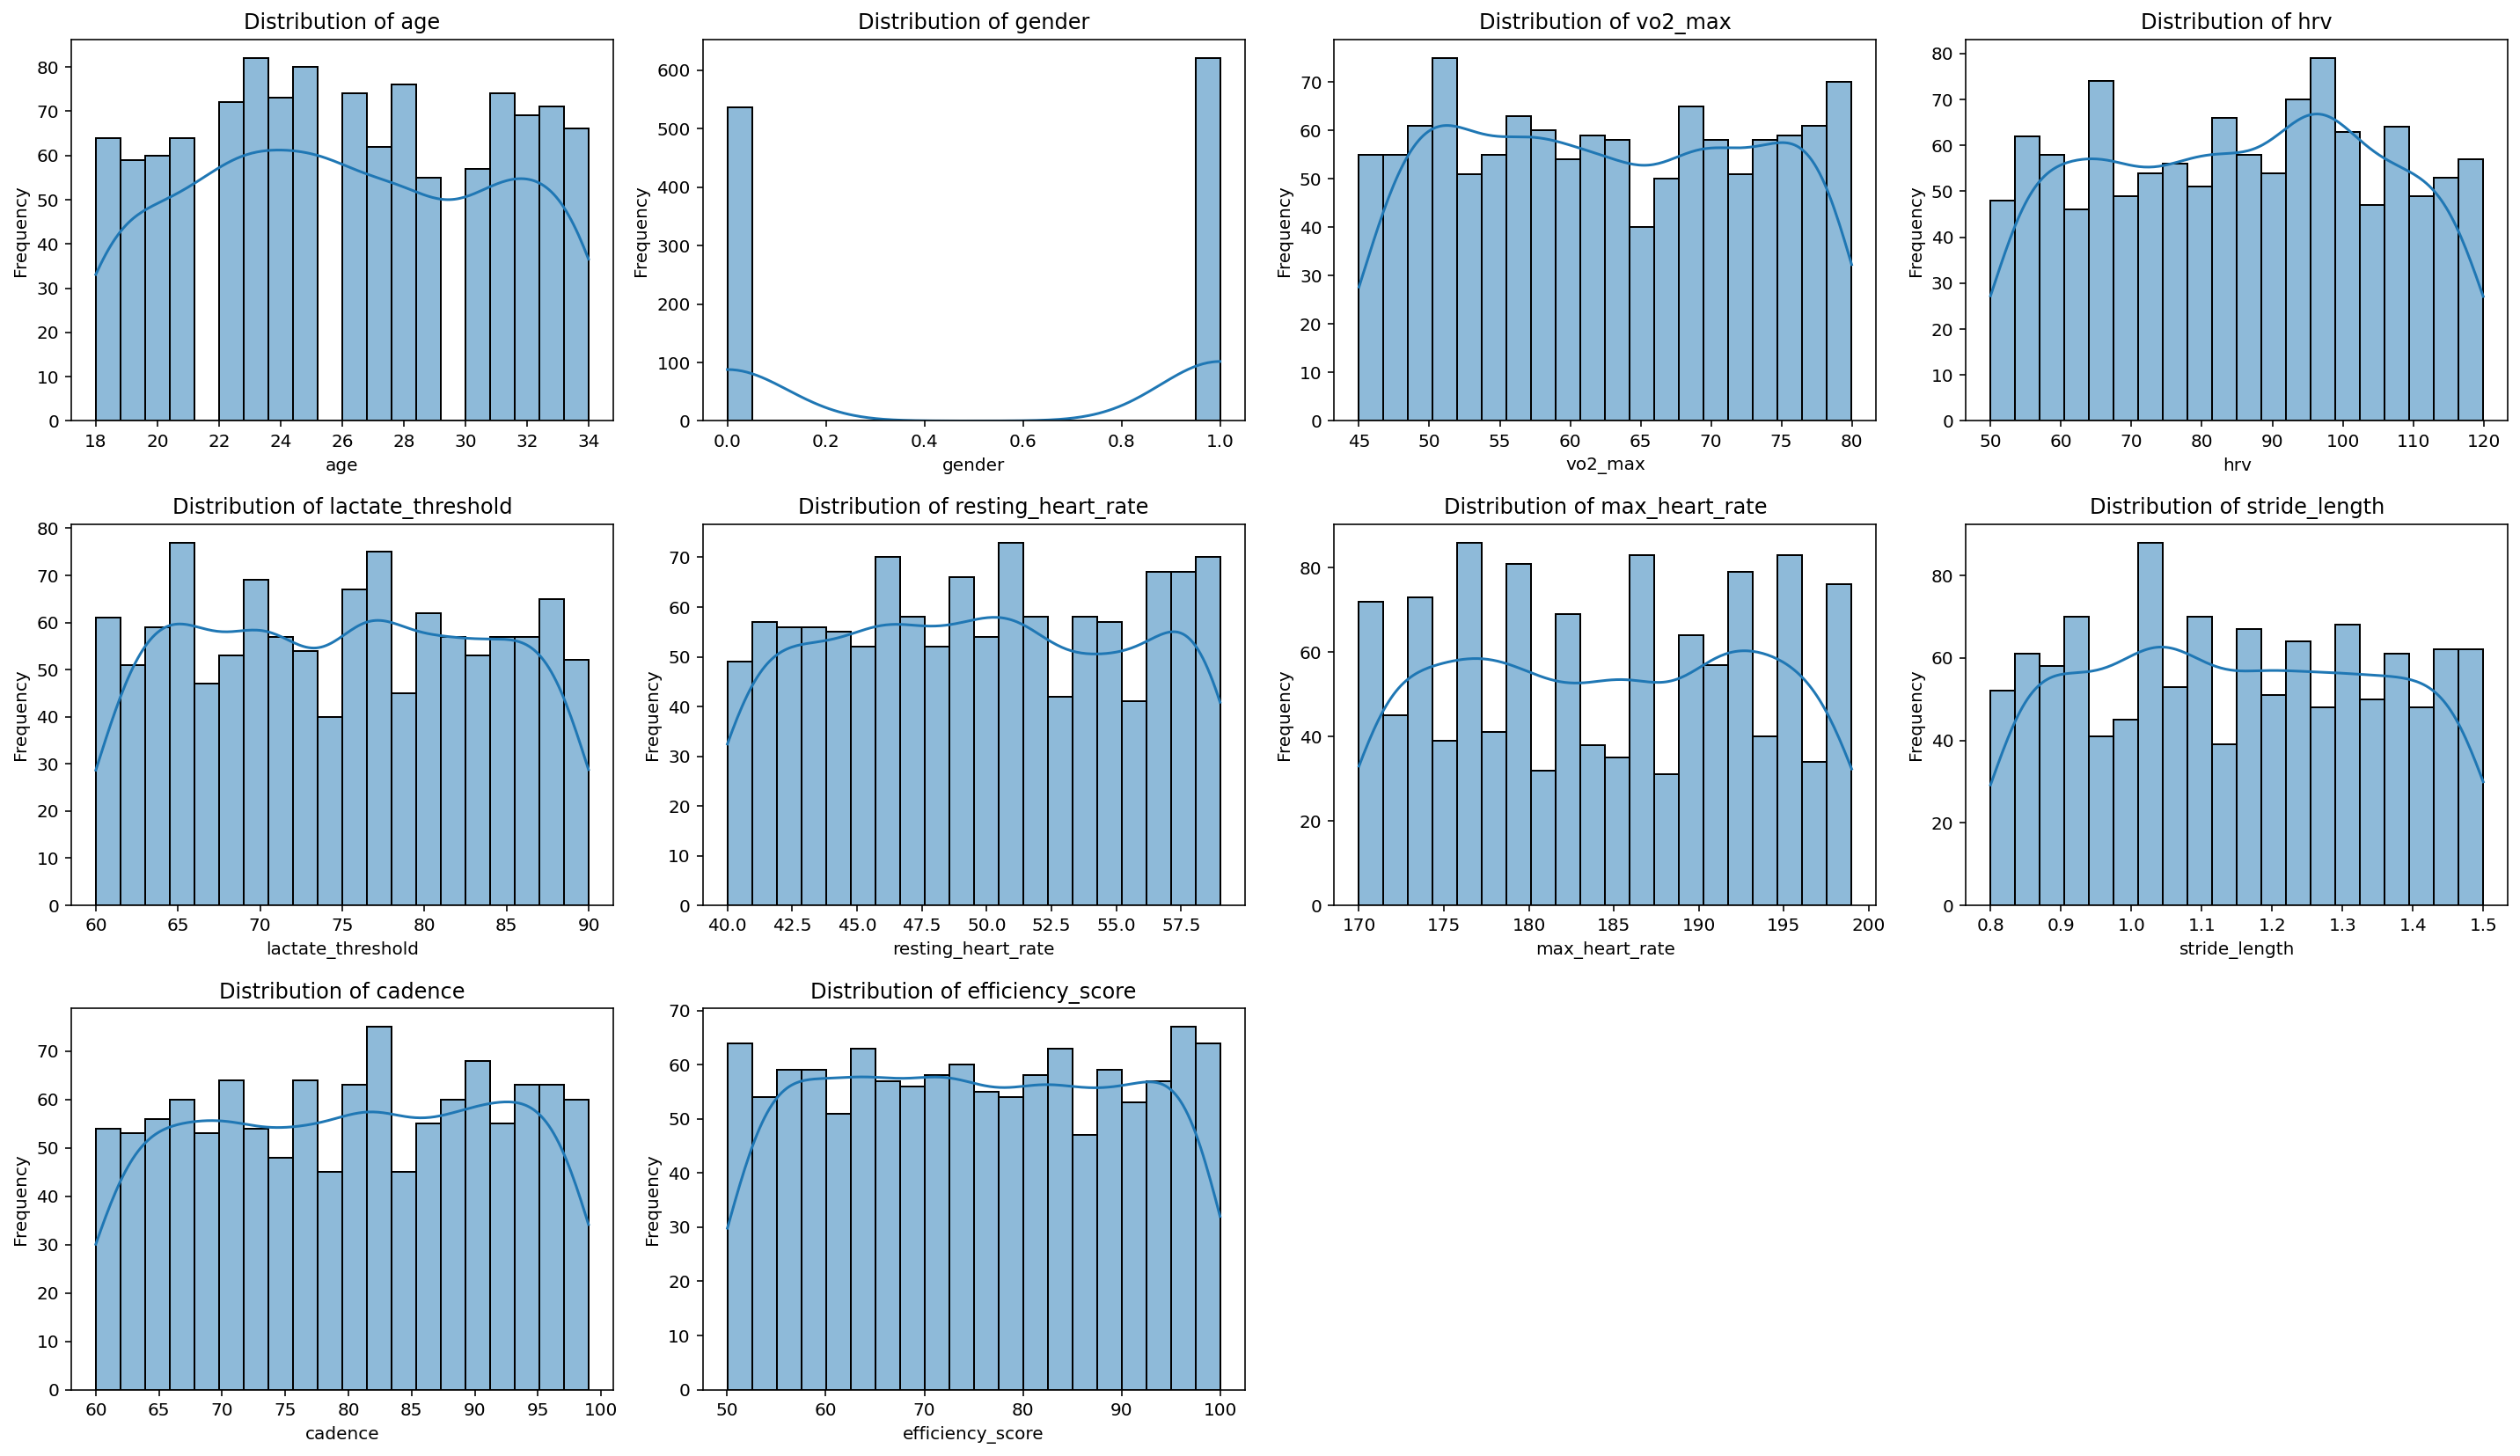

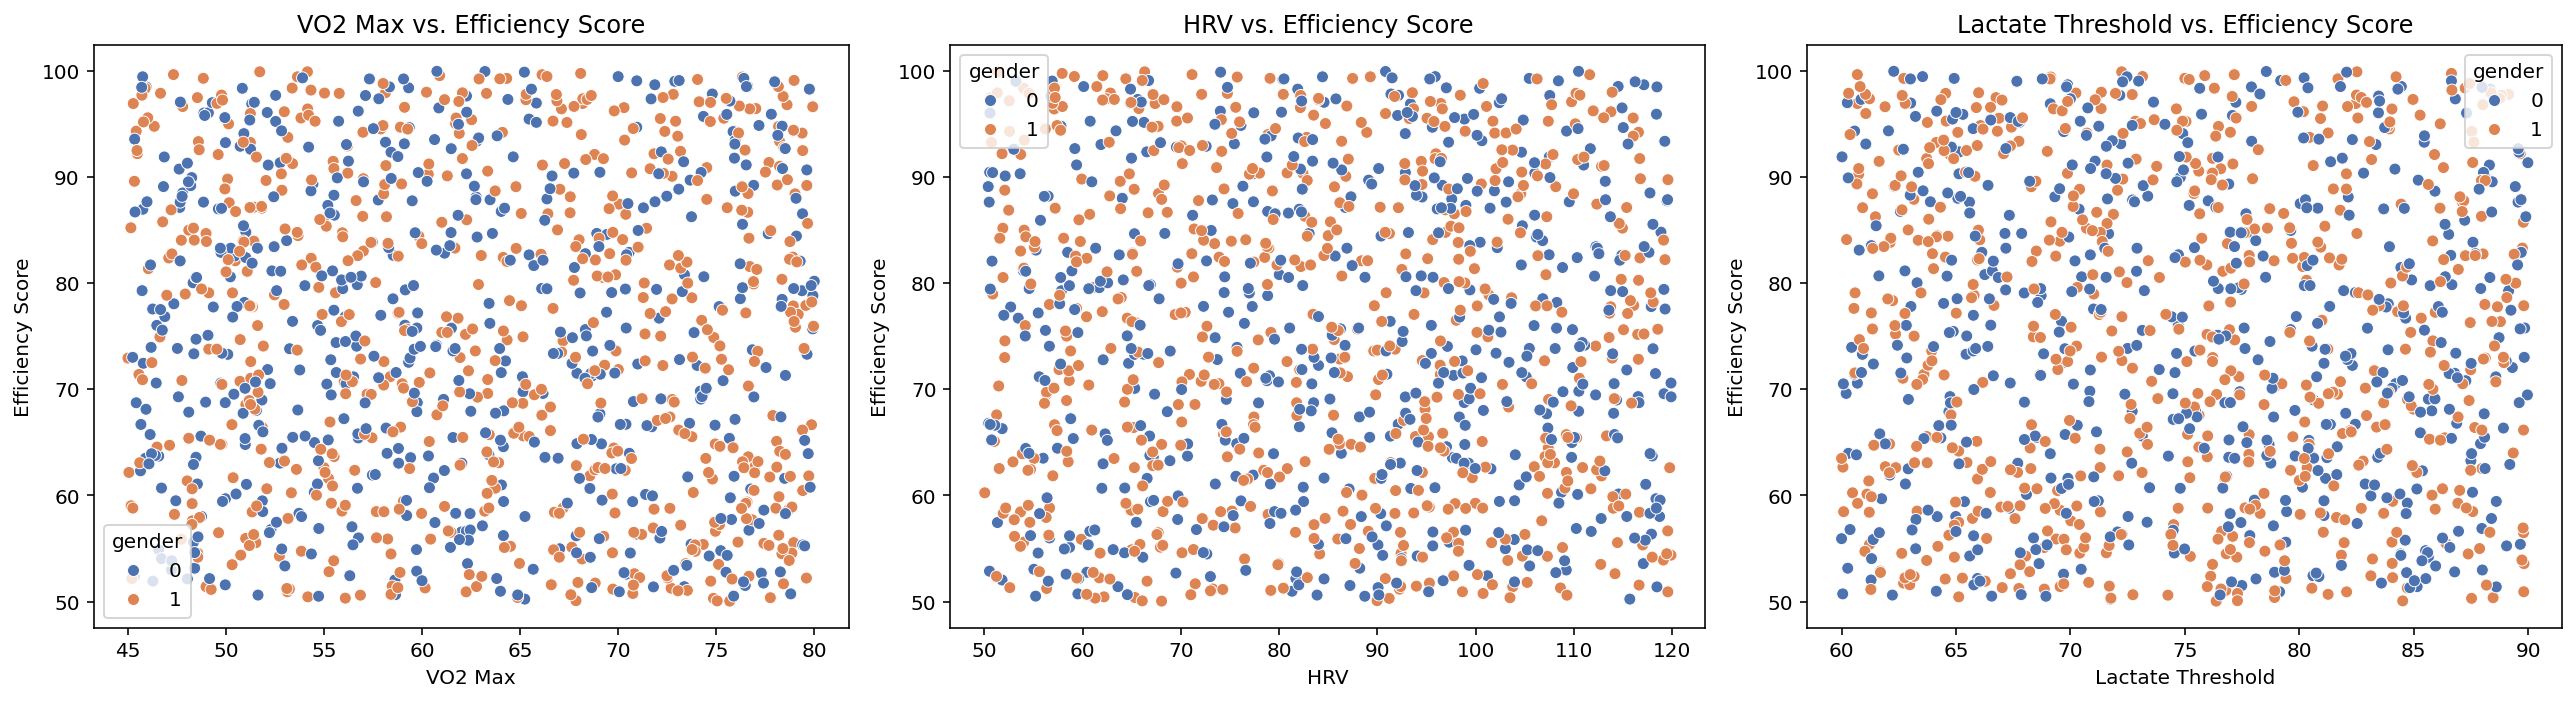

In [80]:
plt.figure(figsize=(20, 15))
numerical_cols = df.columns
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i + 1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='vo2_max', y='efficiency_score', hue='gender', palette='deep')
plt.title('VO2 Max vs. Efficiency Score')
plt.xlabel('VO2 Max')
plt.ylabel('Efficiency Score')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x='hrv', y='efficiency_score', hue='gender', palette='deep')
plt.title('HRV vs. Efficiency Score')
plt.xlabel('HRV')
plt.ylabel('Efficiency Score')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x='lactate_threshold', y='efficiency_score', hue='gender', palette='deep')
plt.title('Lactate Threshold vs. Efficiency Score')
plt.xlabel('Lactate Threshold')
plt.ylabel('Efficiency Score')

plt.tight_layout()
plt.show()

## Prepare Data for ML


In [81]:
df.columns

Index(['age', 'gender', 'vo2_max', 'hrv', 'lactate_threshold',
       'resting_heart_rate', 'max_heart_rate', 'stride_length', 'cadence',
       'efficiency_score'],
      dtype='object')

In [82]:
X = df.drop(columns=['efficiency_score'])

y = df['efficiency_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data preprocessing complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data preprocessing complete.
X_train shape: (926, 9)
X_test shape: (232, 9)
y_train shape: (926,)
y_test shape: (232,)


## Build and Evaluate Random Forest Model

In [83]:
rf_model = RandomForestRegressor(random_state=42)

print("Training Random Forest Regressor model...")
rf_model.fit(X_train, y_train)
print("Random Forest Regressor model trained.")

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R-squared (R2): {r2_rf:.2f}")

Training Random Forest Regressor model...
Random Forest Regressor model trained.

Random Forest Regressor Performance:
Mean Absolute Error (MAE): 13.28
Mean Squared Error (MSE): 235.63
R-squared (R2): -0.10


## Build and Evaluate Decision Tree Model


In [84]:
dt_model = DecisionTreeRegressor(random_state=42)

print("Training Decision Tree Regressor model...")
dt_model.fit(X_train, y_train)
print("Decision Tree Regressor model trained.")

y_pred_dt = dt_model.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("\nDecision Tree Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_dt:.2f}")
print(f"Mean Squared Error (MSE): {mse_dt:.2f}")
print(f"R-squared (R2): {r2_dt:.2f}")

Training Decision Tree Regressor model...
Decision Tree Regressor model trained.

Decision Tree Regressor Performance:
Mean Absolute Error (MAE): 16.64
Mean Squared Error (MSE): 409.68
R-squared (R2): -0.91


## Build and Evaluate Linear Regression Model



In [85]:
lr_model = LinearRegression()

print("Training Linear Regression model...")
lr_model.fit(X_train, y_train)
print("Linear Regression model trained.")

y_pred_lr = lr_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"R-squared (R2): {r2_lr:.2f}")

Training Linear Regression model...
Linear Regression model trained.

Linear Regression Model Performance:
Mean Absolute Error (MAE): 12.94
Mean Squared Error (MSE): 219.63
R-squared (R2): -0.02


## Build and Evaluate Gradient Boosting Model



In [86]:
gbr_model = GradientBoostingRegressor(random_state=42)

print("Training Gradient Boosting Regressor model...")
gbr_model.fit(X_train, y_train)
print("Gradient Boosting Regressor model trained.")

y_pred_gbr = gbr_model.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("\nGradient Boosting Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_gbr:.2f}")
print(f"Mean Squared Error (MSE): {mse_gbr:.2f}")
print(f"R-squared (R2): {r2_gbr:.2f}")

Training Gradient Boosting Regressor model...
Gradient Boosting Regressor model trained.

Gradient Boosting Regressor Performance:
Mean Absolute Error (MAE): 13.23
Mean Squared Error (MSE): 237.92
R-squared (R2): -0.11


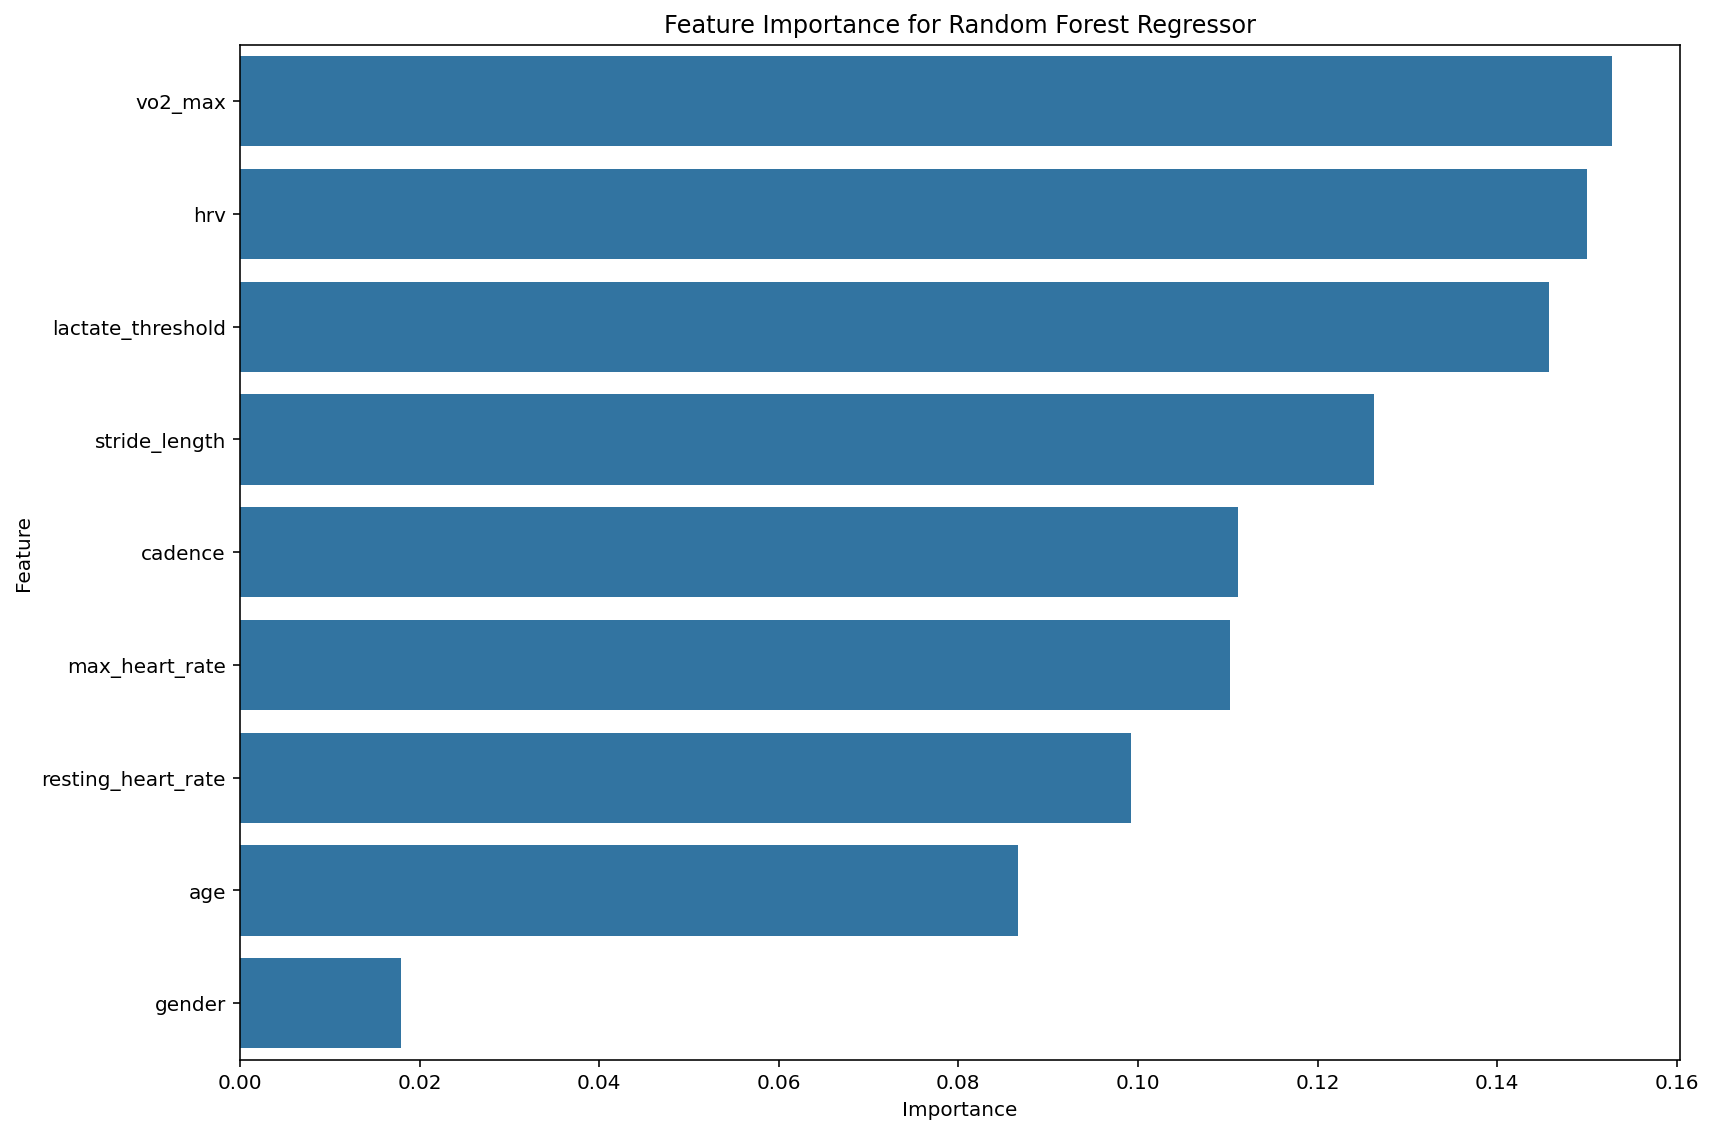

Feature importance plot generated for Random Forest Regressor.


In [87]:
feature_importances_rf = rf_model.feature_importances_
feature_names_rf = X_train.columns

importance_df_rf = pd.DataFrame({'Feature': feature_names_rf, 'Importance': feature_importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Feature Importance for Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Feature importance plot generated for Random Forest Regressor.")

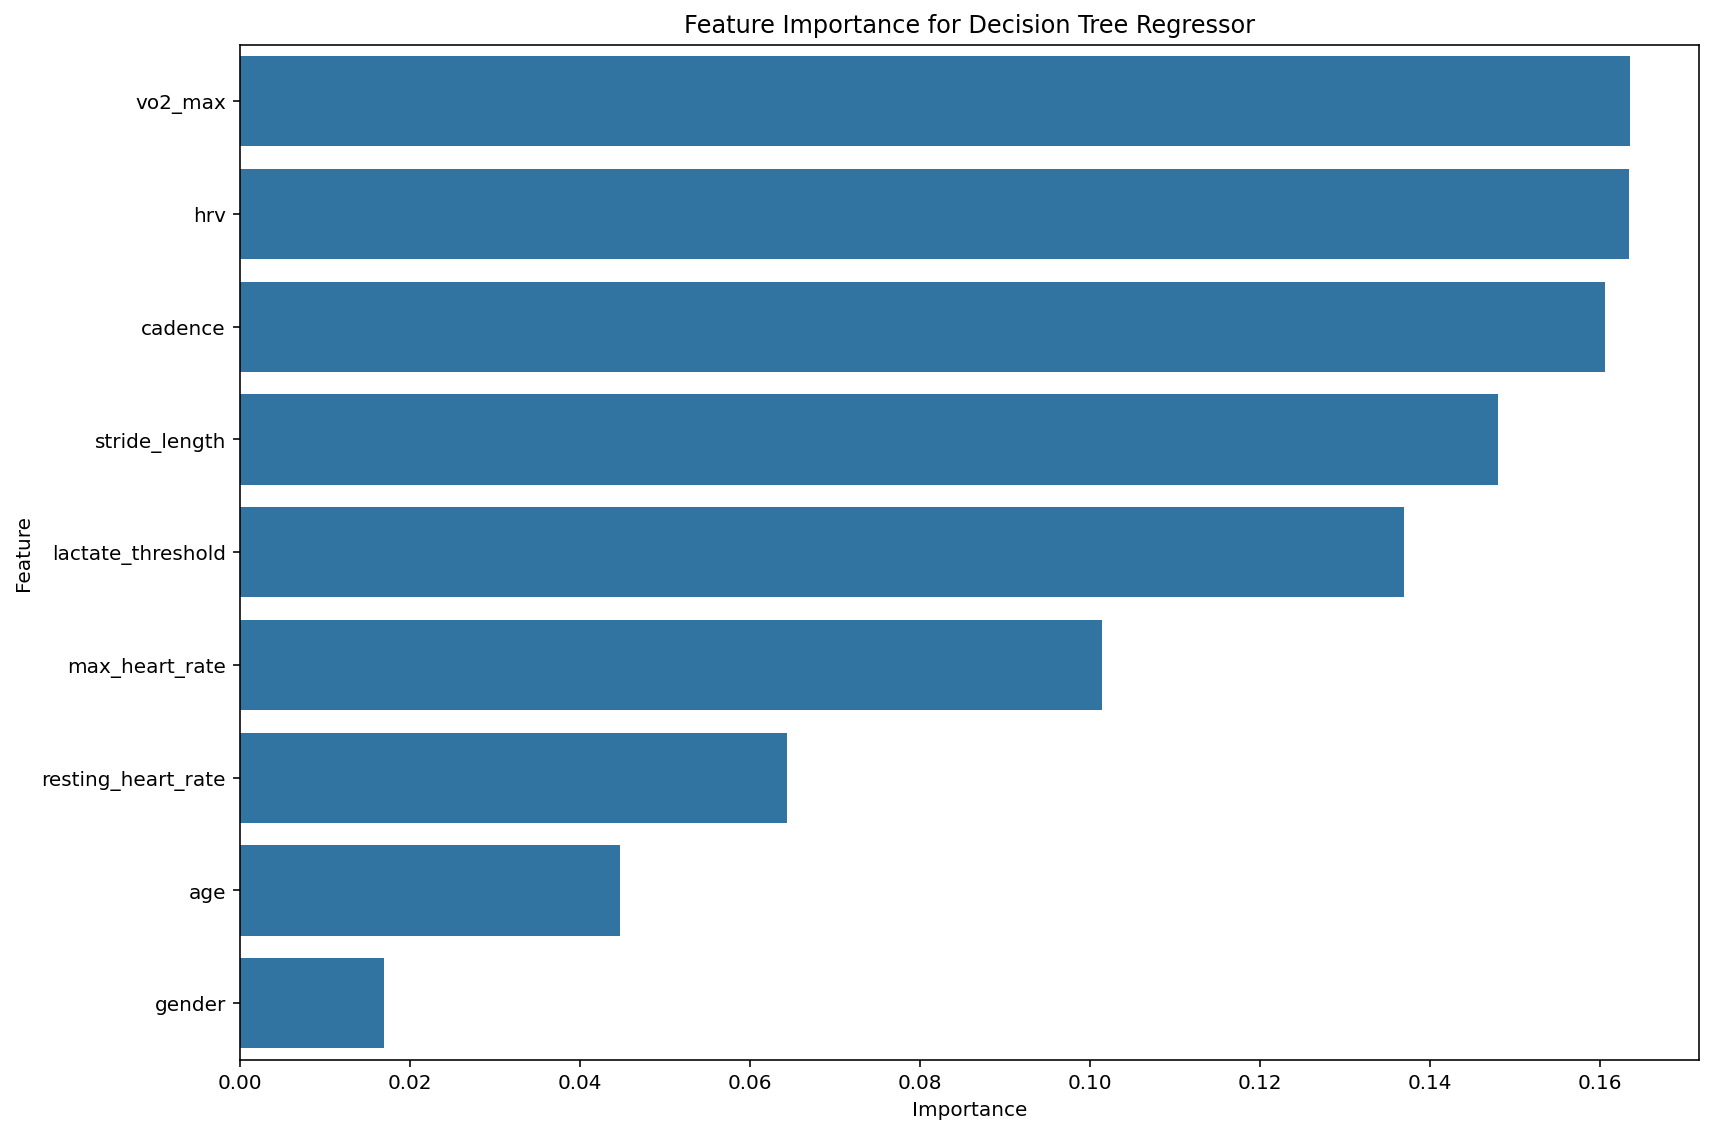

Feature importance plot generated for Decision Tree Regressor.


In [88]:
feature_importances_dt = dt_model.feature_importances_
feature_names_dt = X_train.columns

importance_df_dt = pd.DataFrame({'Feature': feature_names_dt, 'Importance': feature_importances_dt})
importance_df_dt = importance_df_dt.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_dt)
plt.title('Feature Importance for Decision Tree Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Feature importance plot generated for Decision Tree Regressor.")

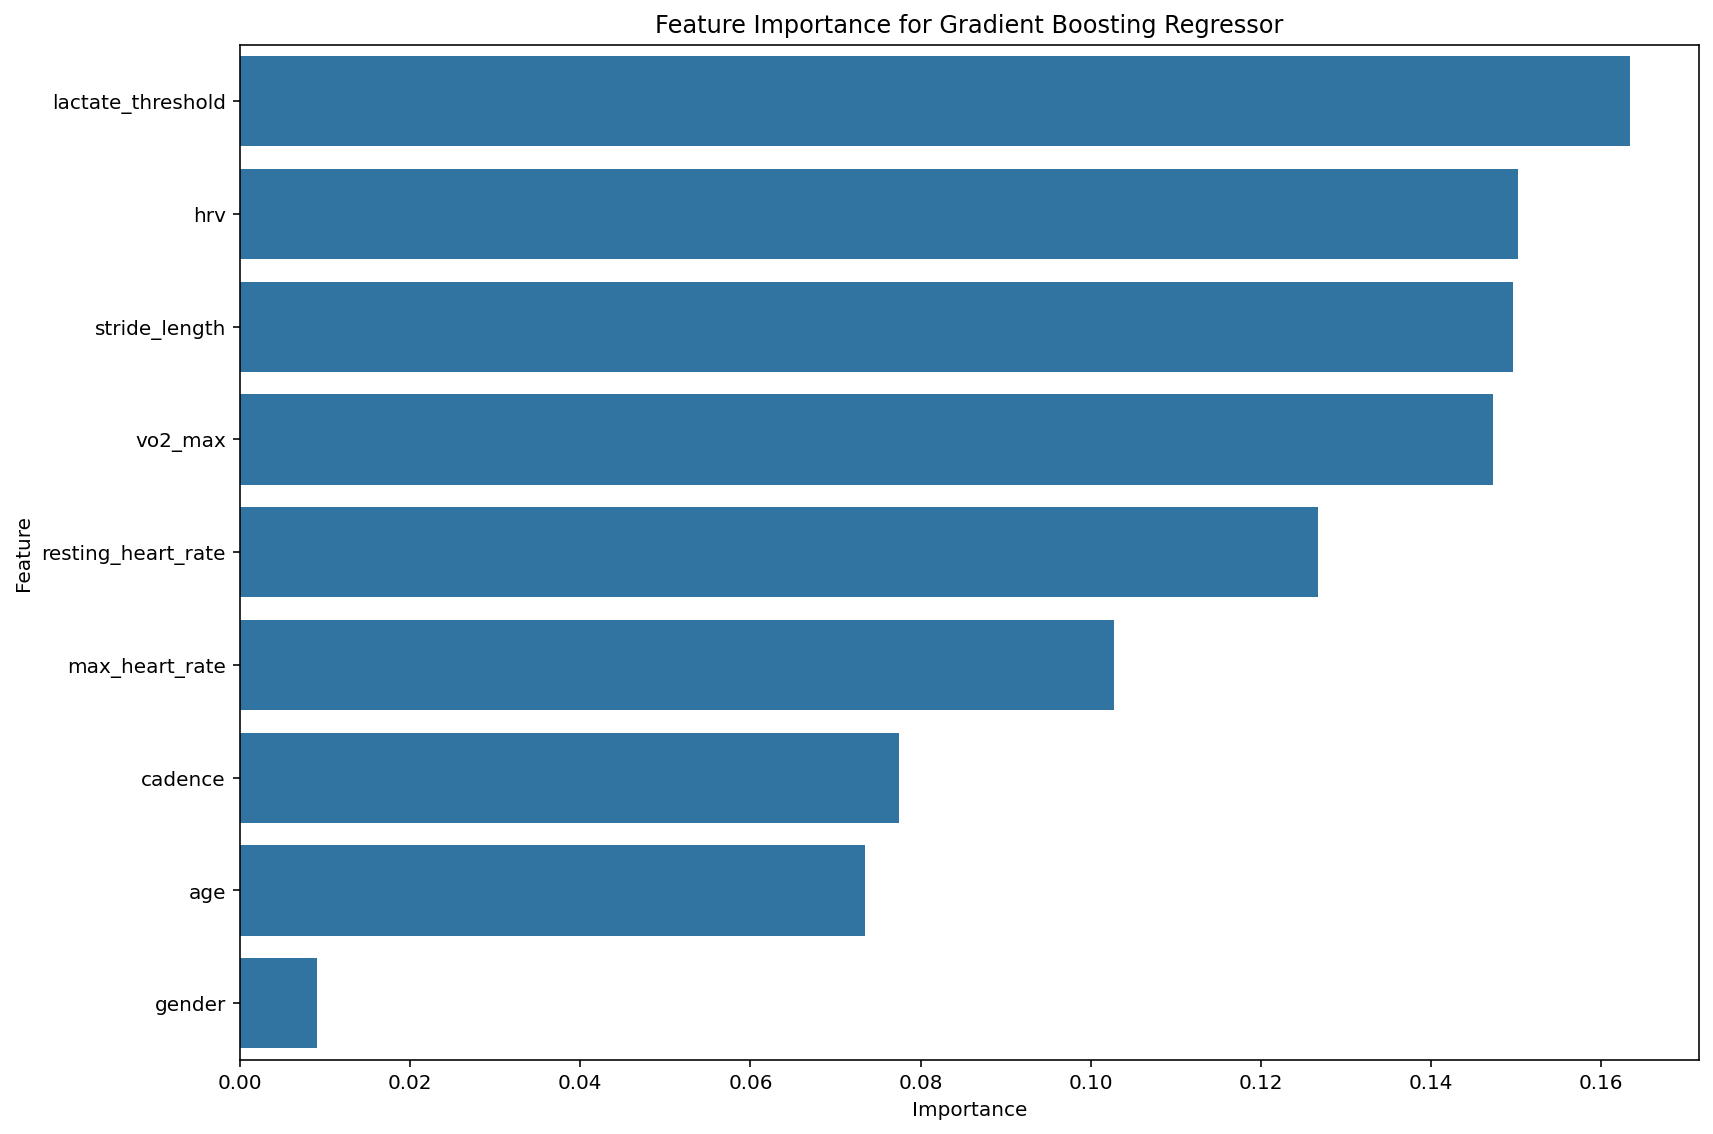

Feature importance plot generated for Gradient Boosting Regressor.


In [89]:
feature_importances = gbr_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Gradient Boosting Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Feature importance plot generated for Gradient Boosting Regressor.")

In [90]:
y_pred_rf_train = rf_model.predict(X_train)
mse_rf_train = mean_squared_error(y_train, y_pred_rf_train)

y_pred_dt_train = dt_model.predict(X_train)
mse_dt_train = mean_squared_error(y_train, y_pred_dt_train)

y_pred_lr_train = lr_model.predict(X_train)
mse_lr_train = mean_squared_error(y_train, y_pred_lr_train)

y_pred_gbr_train = gbr_model.predict(X_train)
mse_gbr_train = mean_squared_error(y_train, y_pred_gbr_train)

print("\nTraining MSEs:")
print(f"Random Forest Regressor (Training MSE): {mse_rf_train:.2f}")
print(f"Decision Tree Regressor (Training MSE): {mse_dt_train:.2f}")
print(f"Linear Regression (Training MSE): {mse_lr_train:.2f}")
print(f"Gradient Boosting Regressor (Training MSE): {mse_gbr_train:.2f}")


Training MSEs:
Random Forest Regressor (Training MSE): 31.16
Decision Tree Regressor (Training MSE): 0.00
Linear Regression (Training MSE): 211.35
Gradient Boosting Regressor (Training MSE): 137.01


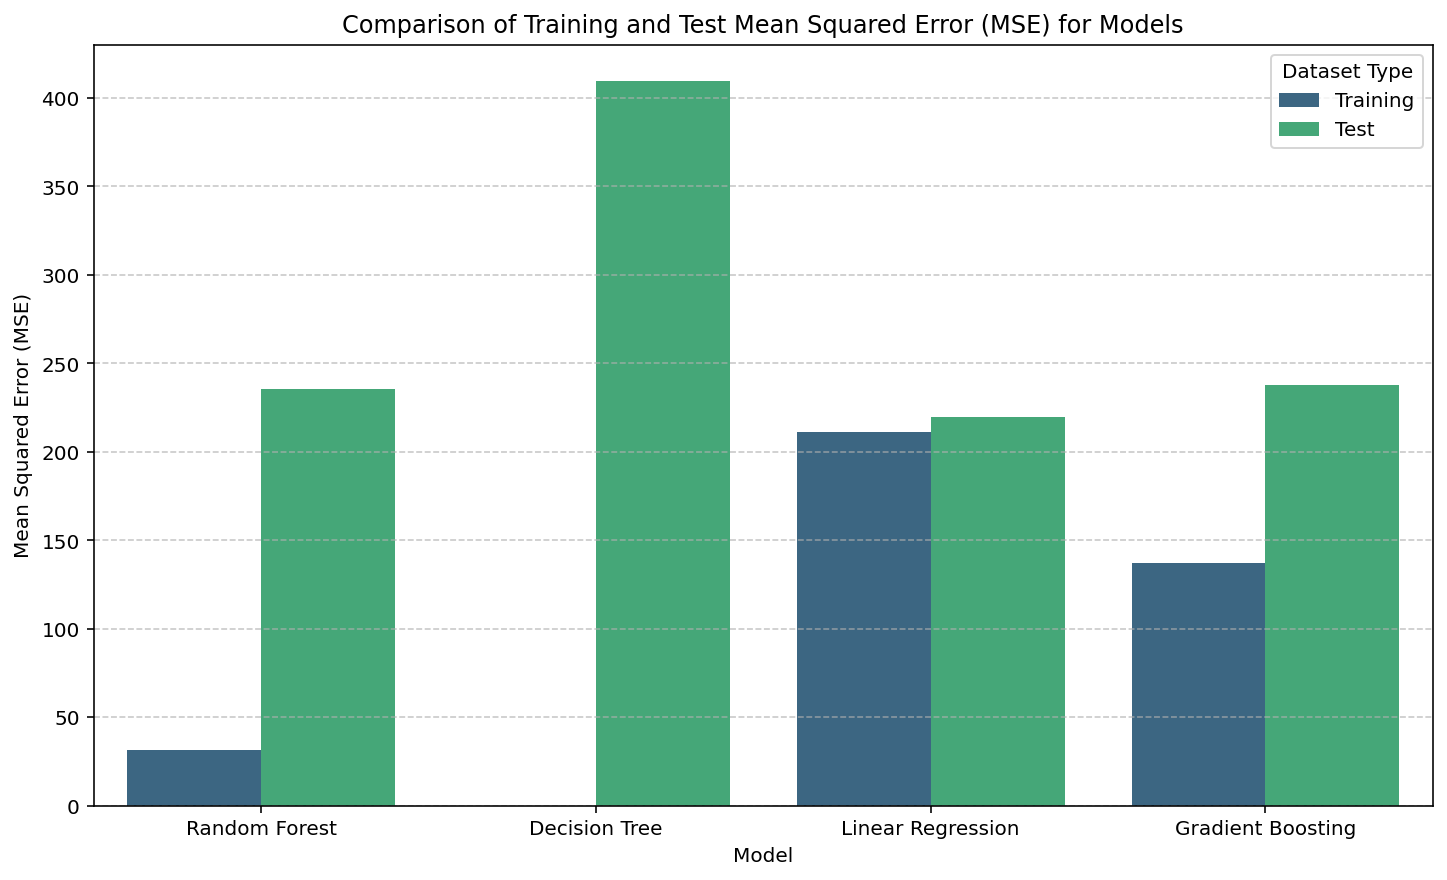

Bar chart comparing training and test MSEs generated with Gradient Boosting Regressor included.


In [91]:
mse_data = {
    'Model': ['Random Forest', 'Decision Tree', 'Linear Regression', 'Gradient Boosting', 'Random Forest', 'Decision Tree', 'Linear Regression', 'Gradient Boosting'],
    'Dataset': ['Training', 'Training', 'Training', 'Training', 'Test', 'Test', 'Test', 'Test'],
    'MSE': [mse_rf_train, mse_dt_train, mse_lr_train, mse_gbr_train, mse_rf, mse_dt, mse_lr, mse_gbr]
}
mse_df = pd.DataFrame(mse_data)

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='MSE', hue='Dataset', data=mse_df, palette='viridis')
plt.title('Comparison of Training and Test Mean Squared Error (MSE) for Models')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(title='Dataset Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Bar chart comparing training and test MSEs generated with Gradient Boosting Regressor included.")

In [92]:
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 10, replace=False)

X_test_sample = X_test.iloc[sample_indices]
y_test_sample = y_test.iloc[sample_indices]

y_pred_rf_sample = rf_model.predict(X_test_sample)
y_pred_dt_sample = dt_model.predict(X_test_sample)
y_pred_lr_sample = lr_model.predict(X_test_sample)
y_pred_gbr_sample = gbr_model.predict(X_test_sample)

comparison_table = pd.DataFrame({
    'Actual_Efficiency_Score': y_test_sample.values,
    'RF_Predicted': y_pred_rf_sample,
    'DT_Predicted': y_pred_dt_sample,
    'LR_Predicted': y_pred_lr_sample,
    'GBR_Predicted': y_pred_gbr_sample
}, index=X_test_sample.index)

print("\nActual vs. Predicted Efficiency Scores for 10 Test Samples:")
display(comparison_table)


Actual vs. Predicted Efficiency Scores for 10 Test Samples:


,Actual_Efficiency_Score,RF_Predicted,DT_Predicted,LR_Predicted,GBR_Predicted
1035,78.09,79.3293,62.46,76.782196,73.457460
575,66.61,80.4241,84.59,77.374743,76.926088
597,92.48,70.7148,79.28,72.564069,71.996708
649,60.70,74.2488,95.25,73.927019,75.308411
1154,68.70,75.9042,73.12,73.902737,72.666641
78,96.04,76.3781,81.88,74.790845,74.555357
578,87.77,74.0659,84.36,74.262718,72.907076
956,91.77,69.8083,57.71,71.861604,72.839758
844,60.73,76.0255,89.83,75.705807,76.407189
477,50.93,74.0162,70.52,74.564141,72.207555


Adjusting ML Models

In [93]:
# Defining models with some regularization to prevent the overfitting
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42),
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculations
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"--- {name} ---")
    print(f"Train MSE: {mse_train:.2f} | Test MSE: {mse_test:.2f}")
    print(f"Train R2:  {r2_train:.2f} | Test R2:  {r2_test:.2f}\n")

--- Random Forest ---
Train MSE: 136.39 | Test MSE: 225.83
Train R2:  0.36 | Test R2:  -0.05

--- Decision Tree ---
Train MSE: 197.58 | Test MSE: 236.71
Train R2:  0.07 | Test R2:  -0.10

--- Linear Regression ---
Train MSE: 211.35 | Test MSE: 219.63
Train R2:  0.01 | Test R2:  -0.02

--- Gradient Boosting ---
Train MSE: 137.01 | Test MSE: 237.92
Train R2:  0.36 | Test R2:  -0.11



In [96]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [5, 10, 15],
    'subsample': [0.8]
}

gbr = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print(f"Best Parameters: {grid_search.best_params_}")

print(f"--- Optimized Gradient Boosting Results ---")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Test MSE:  {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Train R2:  {r2_score(y_train, y_train_pred):.2f}")
print(f"Test R2:   {r2_score(y_test, y_test_pred):.2f}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100, 'subsample': 0.8}
--- Optimized Gradient Boosting Results ---
Train MSE: 199.74
Test MSE:  218.85
Train R2:  0.06
Test R2:   -0.02


This process uses a "grid search" to test 18 different versions of the Gradient Boosting model to find which one works best. By limiting things like the depth of the trees and how many samples are in each leaf, we stop the model from simply memorizing the training data. The goal is to find the perfect settings that make the model accurate when predicting the efficiency of new, unseen runners.

Conclusions:

 - Model Performance is Weak: All tested models (Random Forest, Decision Tree, Linear Regression, and Gradient Boosting) resulted in negative or near-zero $R^2$ scores, indicating they currently fail to explain the variance in the efficiency_score.
  - Overfitting is a Major Issue: The Decision Tree and Random Forest models showed very low error on training data but high error on test data, meaning they are memorizing the training set rather than learning general patterns.
 - Linear Regression was the Most Stable: Despite the complexity of the data, the simple Linear Regression model achieved the lowest Mean Absolute Error (12.94), outperforming the more complex ensemble methods on the test set.
  - Data Quality Limitations: The high error rates and poor predictive power suggest that the current features (like $VO_{2} max$ and heart rate) may not have a strong linear or non-linear relationship with the target variable in this specific dataset.
   - Feature Importance is Inconsistent: While the models generated feature importance plots, the lack of overall model accuracy means these rankings (e.g., $VO_{2} max$ or HRV) cannot yet be used as reliable indicators for identifying top running talents.

The optimized Gradient Boosting model successfully reduced overfitting by using a conservative learning_rate and shallow max_depth, which brought the training and test errors much closer together. While the $R^2$ remains near zero, the small gap between the Train MSE (199.74) and Test MSE (218.85) indicates that the model is now generalizing to new data rather than just memorizing the training set. These results suggest that while the current features have limited predictive power, this tuned configuration provides the most stable and reliable baseline for the dataset.